第3回 データセットとデータローダー

1、データセットとは

ここでいうデータセットとは、深層学習で学習・検証に用いられる画像や音声などのデータと、それらの種類を示す「ラベル」と呼ばれるものの集合です。学習方法によってはラベルが存在しなかったりしますが、最初なのでラベル有りでのデータセットの用意から始めてみます。

ついでに、ラベルを用いて学習する方法を教師あり学習（画像分類など）、使わないものを教師なし学習（重回帰分析・GANなど）といいます。

深層学習において、データセットの存在は不可欠です（てかデータなしで何を学ばせるんだ？って話ですよね笑）。そのため、まずはデータセットの用意から始めないといけません。Pytorchではありがたいことに、直ぐに利用できるデータセットが用意されています。

では、早速pytorchから「FashionMNIST」と呼ばれる洋服のグレースケール画像データセットを呼び出していきましょう!!

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision

In [2]:
#画像データセットはtorchvisionのdatasetクラスの中から選べる
training_data = datasets.FashionMNIST(
    root="data", #データセットのフォルダの名前を決める
    train=True, #学習用のデータにするか否か
    download=True, #データセットがまだダウンロードされていないならダウンロードするか
    transform=ToTensor() #勝手に画像をtensor型にしてくれる
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

これで呼び出しは完了です。では実際に中身を確認してみましょう。

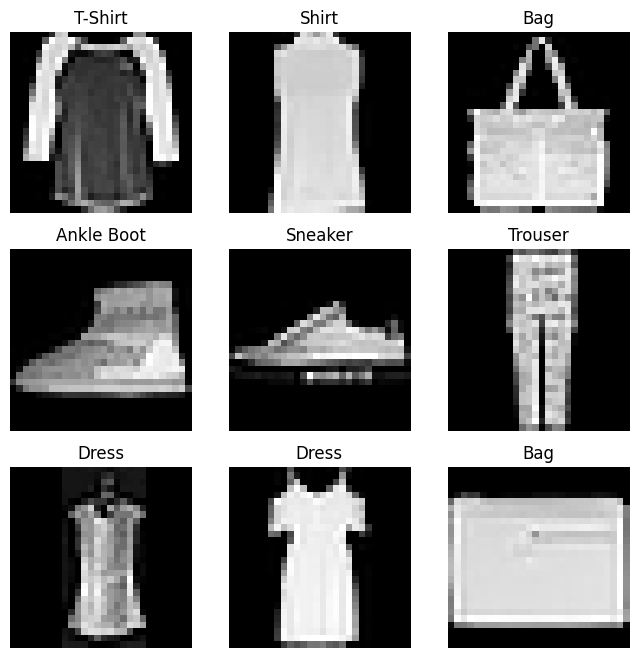

In [3]:
#ラベルに対応するアイテムの名前を格納するディクショナリ
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx] #画像のtensorと、ラベルを代入
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label]) #ラベルを添え字として、ディクショナリの文字列を画像の上に表示する
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

ものすごく粗い画像ですが表示されていますね。これだけ見ると、画像の名前=ラベルというふうに思えますが、ラベルは数値である場合がほとんどです。

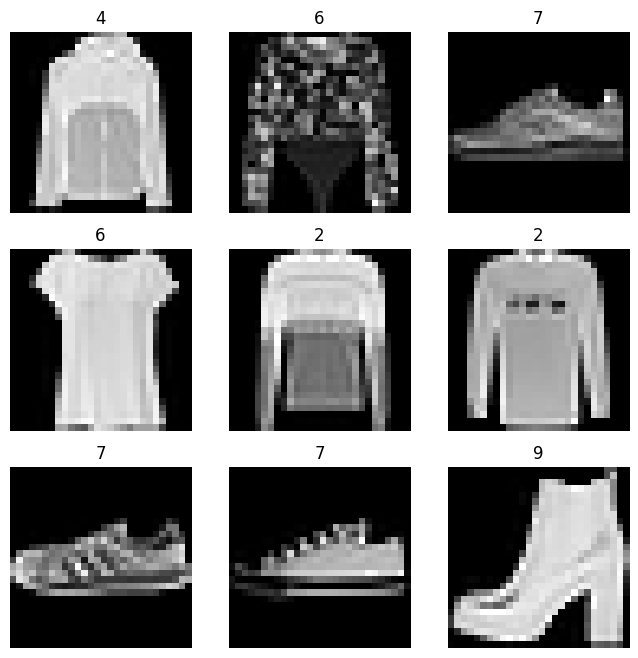

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx] #画像のtensorと、ラベルを代入
    figure.add_subplot(rows, cols, i)
    plt.title(str(label)) #図の名前をラベルそのものにする
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

ラベルがただの数値であることが分かります。

ところで、ディクショナリというものが出てきましたね。これは、深層学習には関係ないのですがPythonの重要なデータ構造の一つなので説明しておきます

ディクショナリとは、ある要素と、その要素を識別するための「キー」を組み合わせたものの集合のことです。

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

この場合だと"T-Shirt"という要素を識別するのに、0という「キー」が使用されています。これにより、ただの数値で表される「ラベル」を「キー」として、画像に写るアイテムの名前を表示しています。Python初学者へのトリックですね。

2、オリジナル画像データセット

Pytorchにはこのようなデータセットがいくつか用意されています

しかし、勘のいい方は気づいているかもしれないのですが、標準で用意されているデータセットなんて使い物になりません。なるとすれば、新しい損失関数の性能評価くらいです。

よって、自ら用意した画像などを用いて、データセットを自作する必要がありますよね？そこで、自作データセットの作り方を説明しようと思います。

ここからは、画像の用意とラベルの作成に入っていきますが、この両者は別の資料に内容を示しました。「plus」ディレクトリの「crawler_base.ipynb」,「csv_base.ipynb」をご覧ください。

まず、データセットを作るには、Pytorchの「Dataset」クラスを継承し、新しいデータセットクラスを作ります

In [5]:
#pandasはデータの読み込みや保存に使うやつ
import pandas as pd
#torchvisionのtransformsは、画像データをtensor型にするための処理をまとめたもの
from torchvision import transforms
from PIL import Image

#クラスの名前のあと、()の中に継承したいクラスの名前を入力する
class My_data(Dataset):

    #コンストラクタ（初期化関数)の呼び出し
    def __init__(self,csv_path,tranceform=None):
        #csvをパスから読み取る
        df=pd.read_csv(csv_path)
        img_paths=df["path"]
        img_label=df["label"]
        self.img_paths=img_paths
        self.img_label=img_label
        self.tranceform=tranceform

    #画像と、画像のパスと、画像のラベルを返す
    def __getitem__(self,idx):
        path=self.img_paths[idx]
        img=Image.open(path)
        #データをtensor型に変換
        if self.tranceform is not None:
            img=self.tranceform(img)
        label=self.img_label[idx]
        return img,label

    #画像の数を示す    
    def __len__(self):
        return len(self.img_paths)

次に、データセット用の画像データとcsvを読み込めるようにしましょう。画像は「dog」と「cat」フォルダに入っているため、この2つのフォルダをimagesフォルダに移動させます。

また、csvファイルは、images/csvsフォルダに移動させましょう。

ここまでのフォルダ構成をまとめておきます。

In [ ]:
"""
images
    |__dog
        |__....
        |__....
        .
        .
        
    |__cat
        |__....
        |__....
        .
        .

    |__csvs
        |__dog_cat.csv

dataset_loader_base.ipynb
.
.

"""

最後に、変換処理と、csvファイルのパスを指定してデータセットを制作しましょう。

In [6]:
#画像サイズを120×120にして、tensor型に変換にする変換処理
trans=transforms.Compose([transforms.Resize((120,120)), transforms.ToTensor()])
#csvファイルのパスと、変換処理を引数にして、インスタンスを作る
dataset=My_data("images/csvs/dog_cat.csv",trans)

print(dataset.__getitem__(3))

(tensor([[[0.3294, 0.3255, 0.3294,  ..., 0.5686, 0.5451, 0.5216],
         [0.3490, 0.3412, 0.3255,  ..., 0.5647, 0.5686, 0.5608],
         [0.3176, 0.3294, 0.3137,  ..., 0.5725, 0.5451, 0.5608],
         ...,
         [0.4118, 0.4078, 0.4000,  ..., 0.7020, 0.7098, 0.7176],
         [0.4078, 0.4039, 0.4078,  ..., 0.7333, 0.7490, 0.7725],
         [0.5529, 0.5451, 0.5686,  ..., 0.8314, 0.8353, 0.8431]],

        [[0.3333, 0.3255, 0.3294,  ..., 0.5255, 0.4980, 0.4706],
         [0.3529, 0.3412, 0.3216,  ..., 0.5255, 0.5294, 0.5176],
         [0.3176, 0.3294, 0.3137,  ..., 0.5333, 0.5059, 0.5216],
         ...,
         [0.2196, 0.2196, 0.2118,  ..., 0.4784, 0.4824, 0.4980],
         [0.2000, 0.1961, 0.1922,  ..., 0.4902, 0.5020, 0.5255],
         [0.3294, 0.3255, 0.3529,  ..., 0.5804, 0.5804, 0.5882]],

        [[0.3490, 0.3373, 0.3373,  ..., 0.5176, 0.4941, 0.4745],
         [0.3608, 0.3490, 0.3333,  ..., 0.5137, 0.5216, 0.5176],
         [0.3255, 0.3412, 0.3216,  ..., 0.5176, 0.4941, 0

datasetの__getitem__メソッドでしっかりと画像のtensorとラベルが表示されましたね。

3、データローダー

これでデータセットは用意できましたね。次は、データセットの画像やラベルを読み込むためのデータローダーを制作します。

このデータローダーは、単に画像やラベルを読み込むだけではありません。実は、一度に読み込める画像やラベルの数を指定することができるのです。

しかし、なぜ、読み込む数を変えることができるといいのでしょう？これは、ミニバッチ法という学習方法の有効性に由来します。

ミニバッチ法とは、データセットの画像を一気に全部読み込むのではなく、小分けにして読み込み学習させるという方法です。画像を一気に読み込んで学習させる方法をバッチ法といいますが、ミニバッチ法はバッチ法よりも早く学習が進むという特徴があります。

では、データローダーを実装してみましょう。

In [7]:
from torch.utils.data import DataLoader

#データローダーはDataLoaderクラスのコンストラクタにデータセット、バッチサイズ、シャッフルの有無などをとって定義します
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


このDataLoaderクラスのbatch_sizeというのが小分けにして読み込む画像の数です。

このデータローダーはpytorch専用のデータセットを読み込んでいるので、今度はオリジナル画像データセットの方を読み込んでみましょう。

In [15]:
dataloader=DataLoader(dataset,batch_size=8,shuffle=True)
features, labels = next(iter(dataloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

Feature batch shape: torch.Size([8, 3, 120, 120])
Labels batch shape: torch.Size([8])


しっかり読み込めてますでしょうか？読み込めていたらデータセットの制作は完了です．

４，もっと楽に作ろう

データセットは通常上記のような方法で制作しますが，画像認識モデル用のデータセット制作の場合に限って，もっと簡単な方法があります．

それは，torchvision.datasets.ImageFolderです.

In [ ]:
# dataset = torchvision.datasets.ImageFolder(root=images_dir, transform=data_transform)

この機能を用いることで，ラベリングや画像パスの読み込みを自動で行ってくれます．ここからは，この機能を用いたデータセットの制作を行っていきましょう．

まずは，imagesフォルダの中身を次のようにしてください．

In [ ]:
"""
images
    |____csvs
    |
    |____train
            |____cat フォルダをコピーする
            |____dog
    |
    |____test
            |____cat
            |____dog

"""

ここではデータセットを訓練用と，検証用で分けていきたいと思います．trainが訓練用で，testが検証用ですね．cat，dogフォルダはそれぞれコピーしてください．

次に，変換処理を書いてみましょう．ここでは，ただ画像をtensor型にするのではなく，正規化やデータの水増しという処理なども実装してみます．transform.Compose（）は，変換処理を記述した配列を引数にとったクラスです．

In [ ]:
image_size=120

mean = (0.5, 0.5, 0.5) #正規化のパラメータ
std = (0.5, 0.5, 0.5) #同様に正規化のパラメータ

data_transform = {
    #訓練用データセットに対する変換処理
    'train': transforms.Compose([
        transforms.RandomResizedCrop( #画像サイズを指定して，ズームアップとか
            image_size, scale=(0.5, 1.0)
        ),
        transforms.RandomHorizontalFlip(), #左右反転
        transforms.RandomRotation(degrees=[-20, 20]), #回転±20°
        transforms.ToTensor(),
        transforms.Normalize(mean, std), #正規化
        transforms.RandomErasing(0.5), #虫食い
    ]),
    #検証用データセットに対する変換処理
    'test': transforms.Compose([
        transforms.Resize(image_size), #画像サイズ変更
        transforms.CenterCrop(image_size), 
        transforms.ToTensor(),
        transforms.Normalize(mean, std) #正規化
    ])
}

上のコードでは，変換処理をディクショナリというPythonのオブジェクトを使って格納しています．もしも，訓練用の変換処理を呼び出したい場合は次のように呼び出す必要があります．

In [ ]:
tf=data_transform["train"] #キーを指定して呼び出す
print(tf)

続いて，データセットとデータローダーの制作に入ります．torchvision.dataset.ImageFolderを使ってみましょう．

In [ ]:
#データセットの制作
train_dataset = torchvision.datasets.ImageFolder(
    root="images/train",  #訓練用データが入ってるパス
    transform=data_transform["train"] #変換処理
)

test_dataset = torchvision.datasets.ImageFolder(
    root="images/test",  #検証用データのパス
    transform=data_transform["test"]
)

#データローダーの制作
train_dataloader=torch.utils.data.DataLoader(
    train_dataset,
    batch_size=30,
    shuffle=True
)

test_dataloader=torch.utils.data.DataLoader(
    test_dataset,
    batch_size=30,
    shuffle=True
)

データローダーの制作までは完了したため，中身を確認していきます．今回はデータに特別な処理を施しているため基に戻してから表示させます．

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5 #正規化の無効化
    npimg = img.numpy() #表示のためにnumpyへ変換
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

data=iter(test_dataloader)
images, labels = next(data)
images=torchvision.utils.make_grid(images)
imshow(images)

うまく確認できましたか？これで今回の講習を終わります．お疲れ様でした．